(Based on the published [notebook](https://github.com/mephistopheies/mlworkshop39_042017/blob/master/3_masterclass/ipy/feature_extraction.ipynb) by Pavel Nesterov; converted to Python 3)

In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Процесс разработки решения топ-15%

<center>Pavel Nesterov</center>
<center>http://pavelnesterov.info/</center>

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
import itertools as it
import pickle
import glob
import os
import string

from scipy import sparse

import nltk
import spacy

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import TruncatedSVD

from scipy.optimize import minimize

import eli5
from IPython.display import display

import xgboost as xgb

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
df_train = pd.read_csv('./../data/train.csv', 
                       dtype={
                           'question1': np.str,
                           'question2': np.str
                       })
df_train['test_id'] = -1
df_test = pd.read_csv('./../data/test.csv', 
                      dtype={
                          'question1': np.str,
                          'question2': np.str
                      })
df_test['id'] = -1
df_test['qid1'] = -1
df_test['qid2'] = -1
df_test['is_duplicate'] = -1

df = pd.concat([df_train, df_test])
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
df['uid'] = np.arange(df.shape[0])
df = df.set_index(['uid'])
print(df.dtypes)
del(df_train, df_test)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



id               int64
is_duplicate     int64
qid1             int64
qid2             int64
question1       object
question2       object
test_id          int64
dtype: object


In [4]:
ix_train = np.where(df['id'] >= 0)[0]
ix_test = np.where(df['id'] == -1)[0]
ix_is_dup = np.where(df['is_duplicate'] == 1)[0]
ix_not_dup = np.where(df['is_duplicate'] == 0)[0]

In [5]:
print(df[df['is_duplicate'] >= 0]['is_duplicate'].value_counts(normalize=True))

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


# Исследуем задачу

<img src="./../images/buben1.jpg" />

## Проверяем тестовый набор данных
<br />

In [ ]:
if len(glob.glob('./../data/tmp/0_*.csv')) < 5:
    df_submit = df.loc[ix_test][['test_id', 'is_duplicate']].copy()
    df_submit['is_duplicate'] = 0.0
    df_submit.to_csv('./../data/tmp/0_zeros.csv', index=False)
    df_submit['is_duplicate'] = 1.0
    df_submit.to_csv('./../data/tmp/0_ones.csv', index=False)
    df_submit['is_duplicate'] = 0.5
    df_submit.to_csv('./../data/tmp/0_half.csv', index=False)
    df_submit['is_duplicate'] = 0.25
    df_submit.to_csv('./../data/tmp/0_quarter.csv', index=False)
    df_submit['is_duplicate'] = 0.75
    df_submit.to_csv('./../data/tmp/0_threequarters.csv', index=False)

In [ ]:
score0 = 6.01888
score1 = 28.52056
score05 = 0.69315
score025 = 0.47913
score075 = 1.19485

Вспомним формуду риска гипотезы:
$$\large Q\left(h\right) = \text{E}_{x, y \sim p\left(x, y\right)}\left[L\left(h\left(x\right), y\right)\right]$$

Тогда эмпирический риск имеет форму:
$$\large Q_{\text{emp}}\left(h\right) = \frac{1}{n}\sum_{i = 1}^n L\left(h\left(x_i\right), y_i\right)$$

Хотя если мы знаем, что распределение меток не равномерное, то можно это учесть, добавив вес примера:
$$\large Q_{\text{emp}}\left(h\right) = \sum_{i = 1}^n w_i L\left(h\left(x_i\right), y_i\right)$$
- где $\sum_{i=1}^n w_i = 1$

В задаче Quora Question Pairs в качестве $L$ используется метрика logloss (вспоминаем логистическую регрессию), а гипотезы выдают вероятность принадлежности к классу дубликатов $h\left(x_i\right) = p_i$:
$$\large\begin{array}{rcl}
Q_{\text{emp}} &=& \frac{1}{n}\sum_{i = 1}^n L\left(h\left(x_i\right), y_i\right) \\
&=& -\frac{1}{n}\sum_{i = 1}^n y_i \log p_i + \left(1 - y_i\right)\log\left(1 - p_i\right) \\
&=& -\frac{1}{n}\sum_{i \in I_0} \log\left(1 - p_i\right) - \frac{1}{n}\sum_{i \in I_1} \log p_i
\end{array}$$

Предположим, что $\forall p_i = 0$, уравнение <font color="blue">(1)</font>:
$$\large\begin{array}{rcl}
q_0 &\approx& -\frac{1}{n}\sum_{i \in I_0} \log\left(1 - \epsilon\right) - \frac{1}{n}\sum_{i \in I_1} \log \epsilon \\
&=& -\frac{n_0}{n}\log\left(1 - \epsilon\right) - \frac{n_1}{n} \log \epsilon \\
&=& -r_0\log\left(1 - \epsilon\right) - r_1 \log \epsilon
\end{array}$$

$\forall p_i = 1$, уравнение <font color="blue">(2)</font>:
$$\large\begin{array}{rcl}
q_1 &\approx& -r_0\log \epsilon - r_1 \log \left(1 - \epsilon\right)
\end{array}$$

$\forall p_i = \frac{1}{2}$, уравнение <font color="blue">(3)</font>:
$$\large\begin{array}{rcl}
q_{1/2} &=& -r_0\log \frac{1}{2} - r_1 \log \frac{1}{2} \\
&=& \left(r_0 + r_1\right) \log 2
\end{array}$$

<font color="blue">(1)</font> + <font color="blue">(2)</font>:
$$\large\begin{array}{rcl}
-\left(q_0+ q_1\right) &=& r_0 \log \left(1 - \epsilon\right) + r_1 \log \epsilon + r_0 \log \epsilon + r_1 \log \left(1 - \epsilon\right) \\
&=& \left(r_0 + r_1\right) \log \epsilon \left(1 - \epsilon\right)
\end{array}$$

Используя уравнение <font color="blue">(3)</font>, вычисляем $\epsilon$:
$$\large\begin{array}{rcl}
-\left(q_0+ q_1\right) &=& \frac{q_{1/2}}{\log 2} \log \epsilon \left(1 - \epsilon\right) \Leftrightarrow \\
\log \epsilon \left(1 - \epsilon\right) &=& \frac{q_0 + q_1}{q_{1/2}} \log \frac{1}{2} \Leftrightarrow \\
\log \epsilon \left(1 - \epsilon\right) &=& A \Leftrightarrow \\
\epsilon^2 - \epsilon + e^A &=& 0 \Rightarrow \\
\epsilon &=& \frac{1}{2}\left(1 \pm \sqrt{1 - 4e^A}\right)
\end{array}$$

In [ ]:
A = (score0 + score1)*np.log(0.5)/score05
print('A =', A)
print('eps_0 =', (1 + np.sqrt(1 - 4*np.exp(A)))/2)
print('eps_1 =', (1 - np.sqrt(1 - 4*np.exp(A)))/2)
eps = 10e-16
print('eps =', eps)

Для простоты написаня введем еще две константы:
$$\large\begin{array}{rcl}
B &=& \log \left(1 - \epsilon\right) \\
C &=& \log \epsilon
\end{array}$$

In [ ]:
B = np.log(1 - eps)
print('B =', B)
C = np.log(eps)
print('C =', C)

Решая систему из двух уравнений <font color="blue">(1)</font> и <font color="blue">(2)</font>, получим:
$$\large\begin{array}{rcl}
r_1 &=& \frac{B\left(q_1 - \frac{C}{B}q_0\right)}{C^2 - B^2} \\
r_0 &=& \frac{1}{C}\left(-q_1 - r_1 B\right)
\end{array}$$

In [ ]:
r1 = (score1 - (C/B)*score0) / ((C*C/B) - B)
print('r1 =', r1)
r0 = (-score1 - r1*B)/C
print('r0 =', r0)
print('r0 + r1 =', r0 + r1)

In [ ]:
if not os.path.isfile('./../data/tmp/0_174.csv'):
    df_submit = df.loc[ix_test][['test_id', 'is_duplicate']].copy()
    df_submit['is_duplicate'] = 0.17426442474
    df_submit.to_csv('./../data/tmp/0_174.csv', index=False)

- score0174 = **0.46258**
- на момент сабмита это **1208/1880**

## Корректируем прогноз модели

Оказывается, что распределение меток на трейне и тесте разное, хотелось бы обучаться на трейне, но как то оптимизировать функцию ошибки на тесте. Сделаем разумное предположение:
 - трейн и тест отличаются только распределением классов, но не данных в класах:
  - $\forall i: p\left(X \mid y = i\right) = p\left(X' \mid y' = i\right)$, где $\left(X, y\right) \sim p_{\text{train}}$, $\left(X', y'\right) \sim p_{\text{test}}$

Обозначим за $p$ лучшую модель на тренировочном наборе данных, тогда:

$$\large\begin{array}{rcl}
p = P\left(y = 1 \mid x\right) &=& \frac{P\left(x \mid y = 1\right)P\left(y = 1\right)}{P\left(x \mid y = 1\right)P\left(y = 1\right) + P\left(x \mid y = 0\right)P\left(y = 0\right)} \\
&=& \frac{a p_1}{a p_1 + b p_0} \Rightarrow \\
b p_0 &=& \frac{a p_1}{p} - a p_1 = \frac{a p_1 - a p_1 p}{p}
\end{array}$$

По предположению, распределение меток на тесте просто скошено, т.е. $P\left(y' = i\right) = \gamma_i P\left(y = 1\right)$, тогда:

$$\large\begin{array}{rcl}
P\left(y' = 1 \mid x\right) &=& \frac{P\left(x \mid y' = 1\right)P\left(y' = 1\right)}{P\left(x \mid y' = 1\right)P\left(y' = 1\right) + P\left(x \mid y' = 0\right)P\left(y' = 0\right)} \\
&=& \frac{a\gamma_1p_1}{a\gamma_1p_1 + b\gamma_0p_0} \\
&=& \frac{a\gamma_1p_1}{a\gamma_1p_1 + \gamma_0\frac{a p_1 - a p_1 p}{p}} \\
&=& \frac{a\gamma_1p_1p}{a\gamma_1p_1p + \gamma_0a p_1 - \gamma_0a p_1 p} \\
&=& \frac{\gamma_1 p}{\gamma_1 p + \gamma_0 - \gamma_0 p} \\
&=& \frac{\gamma_1 p}{\gamma_1 p + \gamma_0 \left(1 - p\right)} \\
\end{array}$$

Получается, что прогноз модели, обученной на тренировочном наборе необходимо перед посылкой преобразовать, используя функцию:
$$\large f\left(x\right) = \frac{\gamma_1 x}{\gamma_1 x + \gamma_0 \left(1 - x\right)}$$

In [ ]:
d = df[df['is_duplicate'] >= 0]['is_duplicate'].value_counts(normalize=True).to_dict()
print('P(y = 0) =', d[0])
print('P(y = 1) =', d[1])
print('P(y\' = 0) =', r0)
print('P(y\' = 1) =', r1)
gamma_0 = r0/d[0]
gamma_1 = r1/d[1]
print('gamma_0 =', gamma_0)
print('gamma_1 =', gamma_1)

def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

support = np.linspace(0, 1, 1000)
values = link_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Link transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

# Извлечение признаков

<img src="./../images/buben2.jpg" width="50%" />

## Длина вопроса
<br />

In [6]:
df['len1'] = df['question1'].str.len().astype(np.float32)
df['len2'] = df['question2'].str.len().astype(np.float32)
df['abs_diff_len1_len2'] = np.abs(df['len1'] - df['len2'])

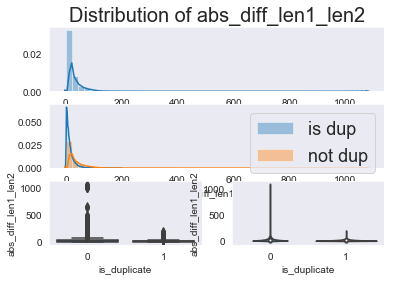

In [7]:
def plot_real_feature(fname):
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=df.loc[ix_train], 
                   ax=ax4)
    plt.show()
    
plot_real_feature('abs_diff_len1_len2')

In [8]:
print(df.loc[ix_train]['abs_diff_len1_len2'].describe())

count    404290.000000
mean         20.158201
std          25.584436
min           0.000000
25%           4.000000
50%          12.000000
75%          26.000000
max        1080.000000
Name: abs_diff_len1_len2, dtype: float64


In [9]:
max_in_dup = df.loc[ix_is_dup]['abs_diff_len1_len2'].max()
print ('Максимум среди дублей:       ', max_in_dup)
max_in_not_dups = df.loc[ix_not_dup]['abs_diff_len1_len2'].max()
print ('Максимум среди не дублей:     ', max_in_not_dups)
print ('Количество строк больше прога: ', (df.loc[ix_train]['abs_diff_len1_len2'] > max_in_dup).sum())
std_in_dups = df.loc[ix_is_dup]['abs_diff_len1_len2'].std()
print ('Стандартное отклонение в дублях:', std_in_dups)
replace_value = max_in_dup + 2*std_in_dups
print ('Новое значение:              ', replace_value)

Максимум среди дублей:        196.0
Максимум среди не дублей:      1080.0
Количество строк больше прога:  394
Стандартное отклонение в дублях: 14.382099
Новое значение:               224.76419830322266


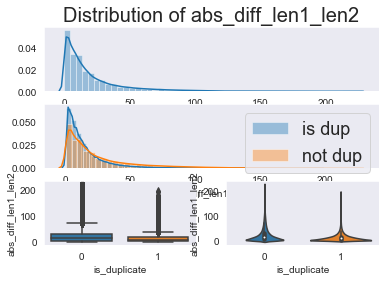

In [10]:
df['abs_diff_len1_len2'] = df['abs_diff_len1_len2'].apply(lambda x: x if x < replace_value else replace_value)
plot_real_feature('abs_diff_len1_len2')

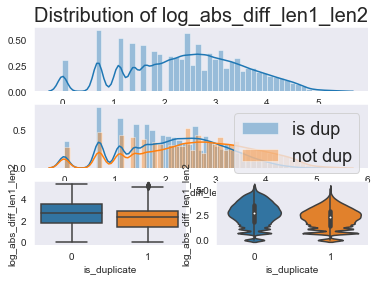

In [11]:
df['log_abs_diff_len1_len2'] = np.log(df['abs_diff_len1_len2'] + 1)
plot_real_feature('log_abs_diff_len1_len2')

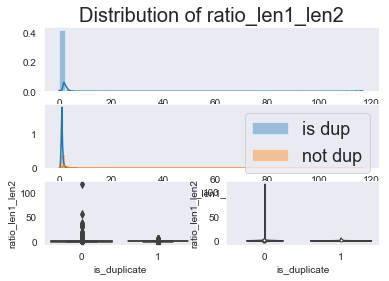

In [12]:
df['ratio_len1_len2'] = df['len1'].apply(lambda x: x if x > 0.0 else 1.0)/\
                        df['len2'].apply(lambda x: x if x > 0.0 else 1.0)
plot_real_feature('ratio_len1_len2')

In [13]:
print (df.loc[ix_train]['ratio_len1_len2'].describe())

count    404290.000000
mean          1.110796
std           0.613775
min           0.006711
25%           0.793651
50%           1.000000
75%           1.271186
max         117.000000
Name: ratio_len1_len2, dtype: float64


In [14]:
max_in_dup = df.loc[ix_is_dup]['ratio_len1_len2'].max()
print ('Максимум среди дублей:        ', max_in_dup)
max_in_not_dups = df.loc[ix_not_dup]['ratio_len1_len2'].max()
print ('Максимум среди не дублей:      ', max_in_not_dups)
print ('Количество строк больше порога: ', (df.loc[ix_train]['ratio_len1_len2'] > max_in_dup).sum())
std_in_dups = df.loc[ix_is_dup]['ratio_len1_len2'].std()
print ('Стандартное отклонение в дублях: ', std_in_dups)
replace_value = max_in_dup + 2*std_in_dups
print ('Новое значение:               ', replace_value)

Максимум среди дублей:         6.666666666666667
Максимум среди не дублей:       117.0
Количество строк больше порога:  152
Стандартное отклонение в дублях:  0.37610604511461654
Новое значение:                7.4188787568959


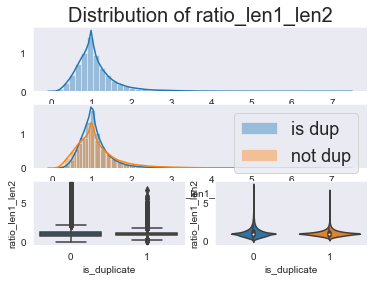

In [15]:
df['ratio_len1_len2'] = df['ratio_len1_len2'].apply(lambda x: x if x < replace_value else replace_value)
plot_real_feature('ratio_len1_len2')

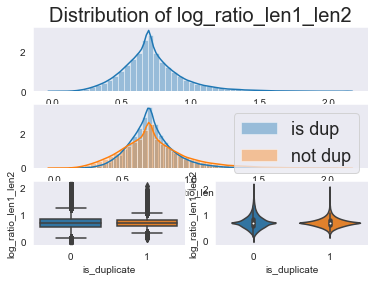

In [16]:
df['log_ratio_len1_len2'] = np.log(df['ratio_len1_len2'] + 1)
plot_real_feature('log_ratio_len1_len2')

In [ ]:
sns.pairplot(df.loc[ix_train][df.columns[7:].tolist() + ['is_duplicate']], hue="is_duplicate")

In [ ]:
sns.jointplot('log_ratio_len1_len2', 'abs_diff_len1_len2', df.loc[ix_train], alpha=0.01)

In [ ]:
def plot_corr(predictors):
    predictors = predictors[:]
    predictors += ['is_duplicate']
    mcorr = df.loc[ix_train][predictors].corr()
    mask = np.zeros_like(mcorr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
    g.set_xticklabels(predictors, rotation=90)
    g.set_yticklabels(reversed(predictors))
    plt.show()
    
plot_corr(df.columns[7:].tolist())

### Проверяем новые признаки

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

def check_model(predictors):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    folder = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                  df.loc[ix_train]['is_duplicate'])
    
    return grid_search

if not os.path.isfile('./../data/tmp/1_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/1_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/1_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  5.5min finished
0.633560068268
{'en__l1_ratio': 0, 'en__alpha': 0.02}
```

<img src="./../images/htop.png" />

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [ ]:
if not os.path.isfile('./../data/tmp/1_pred.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/1_pred.csv', index=False)

In [ ]:
if not os.path.isfile('./../data/tmp/1_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/1_pred_fixed.csv', index=False)

- без поправки: **0.52929**
- с поправкой: **0.44127**
- предыдущее значение: **0.46258**

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors))

## Буквенные n-граммы
<br />

In [18]:
%%time
if os.path.isfile('./../data/tmp/cv_char.pkl') and os.path.isfile('./../data/tmp/ch_freq.pkl'):
    with open('./../data/tmp/cv_char.pkl', 'rb') as f:
        cv_char = pickle.load(f)
    with open('./../data/tmp/ch_freq.pkl', 'rb') as f:
        ch_freq = pickle.load(f)
else:
    cv_char = CountVectorizer(ngram_range=(1, 3), analyzer='char')
    ch_freq = np.array(cv_char.fit_transform(df['question1'].tolist() + df['question2'].tolist()).sum(axis=0))[0, :]
    with open('./../data/tmp/cv_char.pkl', 'wb') as f:
        pickle.dump(cv_char, f)
    with open('./../data/tmp/ch_freq.pkl', 'wb') as f:
        pickle.dump(ch_freq, f)

CPU times: user 180 ms, sys: 24 ms, total: 204 ms
Wall time: 267 ms


In [19]:
unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
ix_unigrams = np.sort(list(unigrams.values()))
print ('Unigrams:', len(unigrams))
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
ix_bigrams = np.sort(list(bigrams.values()))
print ('Bigrams: ', len(bigrams))
trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
ix_trigrams = np.sort(list(trigrams.values()))
print ('Trigrams:', len(trigrams))

Unigrams: 1779
Bigrams:  10723
Trigrams: 74809


In [20]:
%%time
def save_sparse_csr(fname, sm):
    np.savez(fname, 
             data=sm.data, 
             indices=sm.indices,
             indptr=sm.indptr, 
             shape=sm.shape)

def load_sparse_csr(fname):
    loader = np.load(fname)
    return sparse.csr_matrix((
        loader['data'], 
        loader['indices'], 
        loader['indptr']),
        shape=loader['shape'])

if os.path.isfile('./../data/tmp/m_q1.npz') and os.path.isfile('./../data/tmp/m_q2.npz'):
    m_q1 = load_sparse_csr('./../data/tmp/m_q1.npz')
    m_q2 = load_sparse_csr('./../data/tmp/m_q2.npz')
else:
    m_q1 = cv_char.transform(df['question1'].values)
    m_q2 = cv_char.transform(df['question2'].values)
    save_sparse_csr('./../data/tmp/m_q1.npz', m_q1)
    save_sparse_csr('./../data/tmp/m_q2.npz', m_q2)

CPU times: user 6.83 s, sys: 9.49 s, total: 16.3 s
Wall time: 21 s


### Jaccard similarity и производные
$$\large\begin{array}{rcl}
J\left(A, B\right) &=& \dfrac{\left|A \cap B\right|}{\left|A \cup B\right|}
\end{array}$$

#### Униграммы 

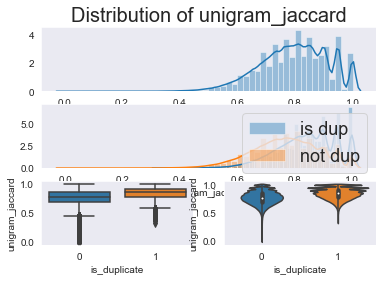

In [21]:
v_num = (m_q1[:, ix_unigrams] > 0).minimum((m_q2[:, ix_unigrams] > 0)).sum(axis=1)
v_den = (m_q1[:, ix_unigrams] > 0).maximum((m_q2[:, ix_unigrams] > 0)).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_jaccard'] = v_score
plot_real_feature('unigram_jaccard')

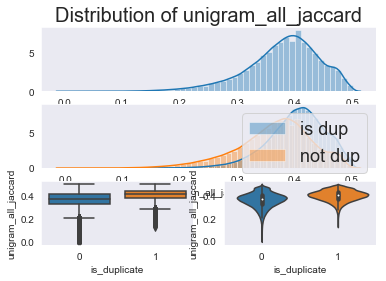

In [22]:
# учитываем каждую букву больше одного раза
v_num = m_q1[:, ix_unigrams].minimum(m_q2[:, ix_unigrams]).sum(axis=1)
v_den = m_q1[:, ix_unigrams].sum(axis=1) + m_q2[:, ix_unigrams].sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_all_jaccard'] = v_score
plot_real_feature('unigram_all_jaccard')

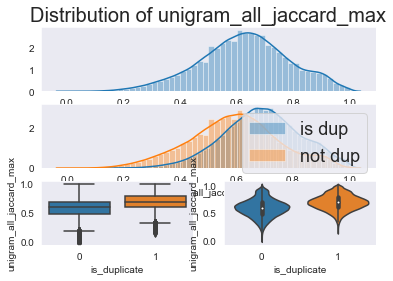

In [23]:
# учитываем каждую букву больше одного раза
# нормируем максимальным значением, а не суммой
v_num = m_q1[:, ix_unigrams].minimum(m_q2[:, ix_unigrams]).sum(axis=1)
v_den = m_q1[:, ix_unigrams].maximum(m_q2[:, ix_unigrams]).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_all_jaccard_max'] = v_score
plot_real_feature('unigram_all_jaccard_max')

#### Биграммы

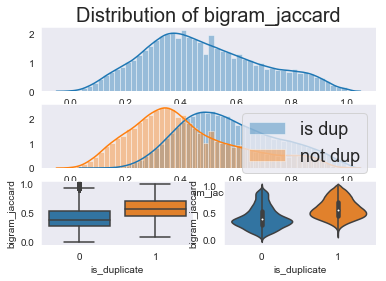

In [24]:
v_num = (m_q1[:, ix_bigrams] > 0).minimum((m_q2[:, ix_bigrams] > 0)).sum(axis=1)
v_den = (m_q1[:, ix_bigrams] > 0).maximum((m_q2[:, ix_bigrams] > 0)).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_jaccard'] = v_score
plot_real_feature('bigram_jaccard')

In [25]:
df.loc[ix_train].groupby(['is_duplicate'])['bigram_jaccard'].agg(
    {
        'min': np.min,
        'max': np.max,
        'p1': lambda x: np.percentile(x, q=0.01),
        'p99': lambda x: np.percentile(x, q=99.99)
    }
)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,min,max,p1,p99
is_duplicate,,,,
0,0.000000,1.0,0.000000,1.0
1,0.083333,1.0,0.116213,1.0


In [26]:
print ('Количество аутлаеров справа:', (df['bigram_jaccard'] > 1).sum())
print ('Количество аутлаеров слева: ', (df['bigram_jaccard'] < -1.47).sum())

Количество аутлаеров справа: 0
Количество аутлаеров слева:  0


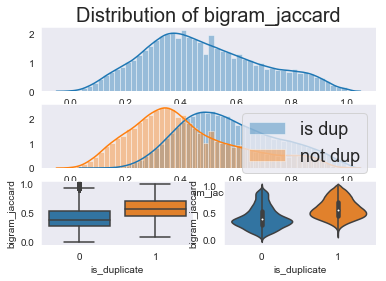

In [27]:
df.loc[df['bigram_jaccard'] < -1.478751, 'bigram_jaccard'] = -1.478751
df.loc[df['bigram_jaccard'] > 1.0, 'bigram_jaccard'] = 1.0
plot_real_feature('bigram_jaccard')

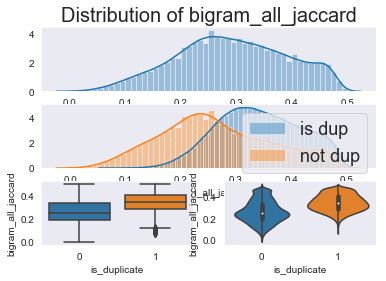

In [28]:
# учитываем каждую букву больше одного раза
v_num = m_q1[:, ix_bigrams].minimum(m_q2[:, ix_bigrams]).sum(axis=1)
v_den = m_q1[:, ix_bigrams].sum(axis=1) + m_q2[:, ix_bigrams].sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_all_jaccard'] = v_score
plot_real_feature('bigram_all_jaccard')

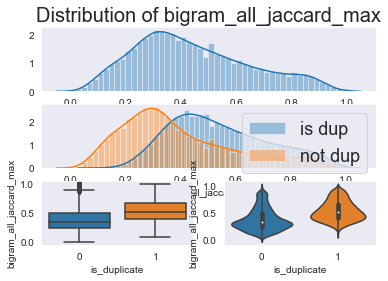

In [29]:
# учитываем каждую букву больше одного раза
# нормируем максимальным значением, а не суммой
v_num = m_q1[:, ix_bigrams].minimum(m_q2[:, ix_bigrams]).sum(axis=1)
v_den = m_q1[:, ix_bigrams].maximum(m_q2[:, ix_bigrams]).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_all_jaccard_max'] = v_score
plot_real_feature('bigram_all_jaccard_max')

#### Триграмы

In [30]:
m_q1 = m_q1[:, ix_trigrams]
m_q2 = m_q2[:, ix_trigrams]

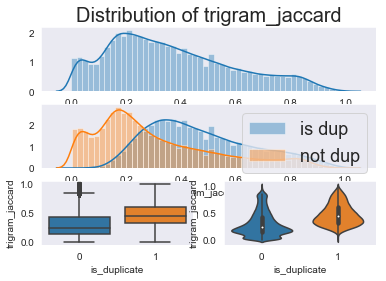

In [31]:
v_num = (m_q1 > 0).minimum((m_q2 > 0)).sum(axis=1)
v_den = (m_q1 > 0).maximum((m_q2 > 0)).sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_jaccard'] = v_score
plot_real_feature('trigram_jaccard')

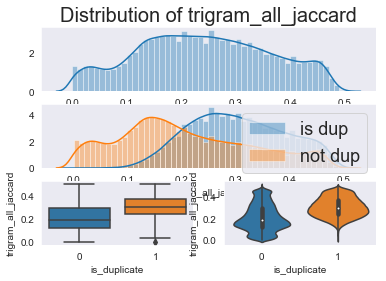

In [32]:
# учитываем каждую букву больше одного раза
v_num = m_q1.minimum(m_q2).sum(axis=1)
v_den = m_q1.sum(axis=1) + m_q2.sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_all_jaccard'] = v_score
plot_real_feature('trigram_all_jaccard')

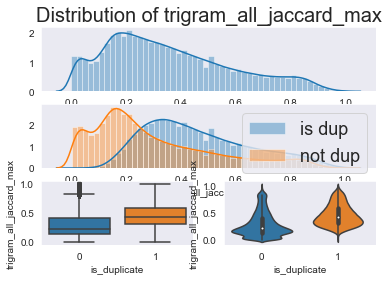

In [33]:
# учитываем каждую букву больше одного раза
# нормируем максимальным значением, а не суммой
v_num = m_q1.minimum(m_q2).sum(axis=1)
v_den = m_q1.maximum(m_q2).sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_all_jaccard_max'] = v_score
plot_real_feature('trigram_all_jaccard_max')

### Tf-idf и попарные метрики на триграмах

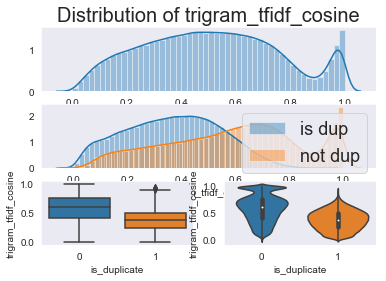

In [34]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
        np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
v_num[np.where(v_den == 0)] = 1
v_den[np.where(v_den == 0)] = 1

v_score = 1 - v_num/v_den

df['trigram_tfidf_cosine'] = v_score
plot_real_feature('trigram_tfidf_cosine')

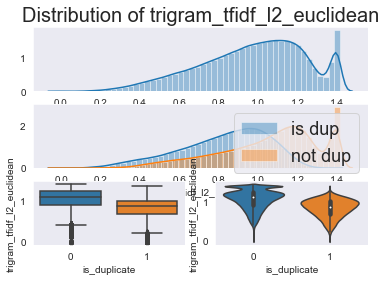

In [35]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tfidf_l2_euclidean'] = v_score
plot_real_feature('trigram_tfidf_l2_euclidean')

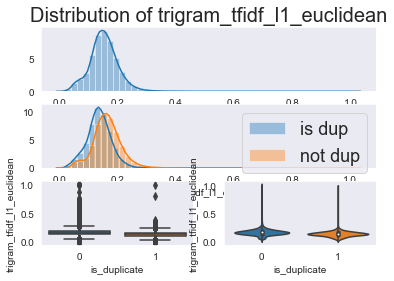

In [36]:
tft = TfidfTransformer(
    norm='l1', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tfidf_l1_euclidean'] = v_score
plot_real_feature('trigram_tfidf_l1_euclidean')

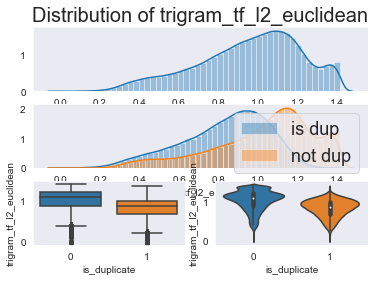

In [37]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tf_l2_euclidean'] = v_score
plot_real_feature('trigram_tf_l2_euclidean')

### Проверяем с новыми признаками

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

In [ ]:
plot_corr(predictors)

In [ ]:
sns.pairplot(df.loc[ix_train][[
    'abs_diff_len1_len2', 
    'trigram_jaccard',
    'trigram_tfidf_cosine', 
    'trigram_tfidf_l2_euclidean', 
    'trigram_tfidf_l1_euclidean',
    'is_duplicate']], hue="is_duplicate")

In [ ]:
if not os.path.isfile('./../data/tmp/2_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/2_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/2_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  8.4min finished
0.716752825942
{'en__l1_ratio': 1, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/2_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/2_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors))

- Старое значение: **0.44127**
- Новый результат: **0.39816**

### Out-of-fold prediction на триграмах

<img src="./../images/buben3.jpg" />

#### Используем tf-idf

In [ ]:
def check_model(predictors, data=None, do_scaling=True):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    folder = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('./../data/tmp/3_model.pkl'):
    model = check_model(None, data={
        'X': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/3_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/3_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 46.3min finished
0.741522174677
{'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(
    sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/3_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/3_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Старое значение: **0.39816**
- Новый результат: **0.36629**

In [ ]:
tmp = set(ix_trigrams.tolist())
tmp = [k for (k, v) in sorted(cv_char.vocabulary_.items(), key=lambda t: t[1]) if v in tmp]
tmp = tmp + tmp
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[0][1],
        feature_names=tmp))

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: 'o v' in s)]['question1'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: 'o v' in s)]['question2'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: '.co' in s)]['question1'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: '.co' in s)]['question2'].tolist()

<img src="./../images/oof.png" />

In [38]:
data = {
    'X_train': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [39]:
if not os.path.isfile('./../data/tmp/4_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.0001,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/4_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/4_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

Необходимо пофиксить распределение, хотя бы среднее значение, воспользуемся уже знакомым преобразованием:

$$\large g\left(x\right) = \frac{w_1 x}{w_1 x + w_0 \left(1 - x\right)} = \frac{w x}{w x + (1 - w) \left(1 - x\right)}$$

- $w \in \left[0, 1\right]$

Условие:

$$\large\begin{array}{rcl}
\mathbb{E}\left[p\right] = \mathbb{E}\left[g\left(q\right)\right]
\end{array}$$
- $p$ - распределение на тренировочном наборе
- $q$ - распределение на тестовом наборе

Можно составить уравнение:

$$\large\begin{array}{rcl}
\frac{1}{n} \sum_{i=1}^n p_i &=& \frac{1}{m} \sum_{i=1}^m g\left(q_i\right) \Rightarrow \\
\mu_p &=& \frac{1}{m} \sum_{i=1}^n \frac{wq_i}{wq_i + \left(1 - w\right)\left(1 - q_i\right)} 
\end{array}$$

Получается следующая задача оптимизации:
$$\large \hat{w} = \arg\min_w \left(\mu_p - \frac{1}{m} \sum_{i=1}^n \frac{wq_i}{wq_i + \left(1 - w\right)\left(1 - q_i\right)}\right)^2 $$

In [40]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

0.36944607019869374
2187887344478.122
      fun: 8.428638216930092e-05
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00064127])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 11
   status: 0
  success: True
        x: array([0.55376469])


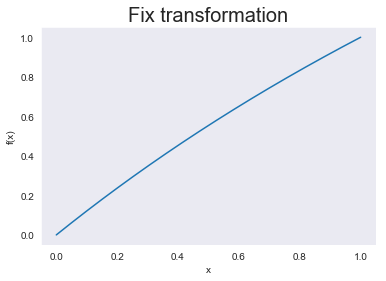

In [41]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [42]:
df['m_q1_q2_tf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_q1_q2_tf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_q1_q2_tf_oof'] = data['y_test_pred_fixed']
del(data)

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('./../data/tmp/5_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/5_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/5_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  9.1min finished
0.784444334512
{'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/5_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/5_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors))

- Старое значение: **0.39816** и **0.36629**
- Новый результат: **0.3316**

In [ ]:
plot_real_feature('m_q1_q2_tf_oof')

In [43]:
del(unigrams, bigrams, trigrams)

### Факторизация горизонтально сконкатенированной матрицы и опять OOF

<img src="./../images/buben4.jpg" />

<br />

<img src="./../images/mf1.png" />

In [44]:
if not os.path.isfile('./../data/tmp/1_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf))))
    with open('./../data/tmp/1_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('./../data/tmp/1_m_svd.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    with open('./../data/tmp/1_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('./../data/tmp/1_m_svd.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

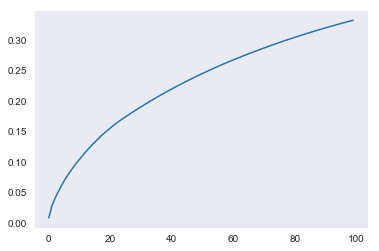

In [45]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

ax1.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 1],
            color='g', alpha=0.1, label='not dub')
ax1.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 1],
            color='r', alpha=0.1, label='dub')
ax1.set_title('rSVD: 0 vs 1')
ax1.legend(loc='upper right', prop={'size': 18})

ax2.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 2],
            color='g', alpha=0.1)
ax2.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 2],
            color='r', alpha=0.1)
ax2.set_title('rSVD: 0 vs 2')

ax3.scatter(m_svd[np.where(df['is_duplicate'] == 0), 1], 
            m_svd[np.where(df['is_duplicate'] == 0), 2],
            color='g', alpha=0.1)
ax3.scatter(m_svd[np.where(df['is_duplicate'] == 1), 1], 
            m_svd[np.where(df['is_duplicate'] == 1), 2],
            color='r', alpha=0.1)
ax3.set_title('rSVD: 1 vs 2')

ax4.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 3],
            color='g', alpha=0.1)
ax4.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 3],
            color='r', alpha=0.1)
ax4.set_title('rSVD: 0 vs 3')

plt.show()

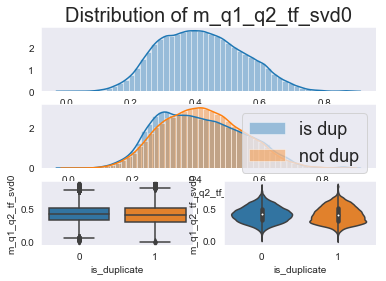

In [46]:
df['m_q1_q2_tf_svd0'] = m_svd[:, 0]
plot_real_feature('m_q1_q2_tf_svd0')

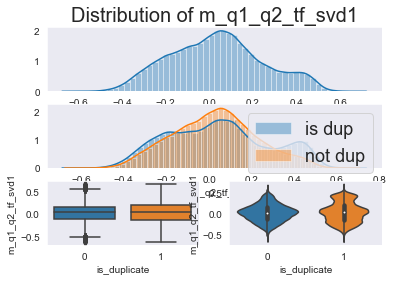

In [47]:
df['m_q1_q2_tf_svd1'] = m_svd[:, 1]
plot_real_feature('m_q1_q2_tf_svd1')

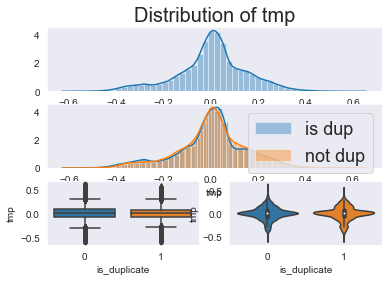

In [48]:
df['tmp'] = m_svd[:, 4]
plot_real_feature('tmp')
df = df.drop('tmp', axis=1)

In [ ]:
if not os.path.isfile('./../data/tmp/6_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/6_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/6_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 31.9min finished
0.68117193104
{'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(m_svd[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/6_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/6_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Результат: **0.41092**

In [49]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [50]:
if not os.path.isfile('./../data/tmp/7_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.5,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/7_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/7_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [51]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

0.3703337544965632
2181731531049.7178
      fun: 0.00010042839608055774
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00116664])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 10
   status: 0
  success: True
        x: array([0.51660609])


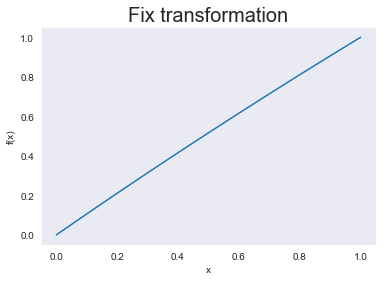

In [52]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [53]:
df['m_q1_q2_tf_svd100_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_q1_q2_tf_svd100_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_q1_q2_tf_svd100_oof'] = data['y_test_pred_fixed']
del(data)

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('./../data/tmp/8_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/8_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/8_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.1min finished
0.785762695095
{'en__l1_ratio': 0.001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/8_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/8_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Старое значение: **0.36629**
- Новый результат: **0.3316**
- Новое значение, но не улучшение: **0.33694**
- Хочется верить, что это погрешность

In [ ]:
plot_real_feature('m_q1_q2_tf_svd100_oof')

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors,
        top=30))

In [ ]:
sns.jointplot('m_q1_q2_tf_oof', 'm_q1_q2_tf_svd100_oof', df.loc[ix_train], kind='reg')

### Пробуем разницу вместо конкатенации

<img src="./../images/mf2.png" />

In [54]:
del(m_q1, m_q2, m_svd)

In [55]:
m_diff_q1_q2 = m_q1_tf - m_q2_tf

In [ ]:
if not os.path.isfile('./../data/tmp/9_model.pkl'):
    model = check_model(None, data={
        'X': m_diff_q1_q2[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/9_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/9_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 36.1min finished
0.630802146974
{'en__l1_ratio': 0.01, 'en__alpha': 0.001}
```

In [ ]:
y_test_pred = model.predict_proba(m_diff_q1_q2[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/9_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/9_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- результат: **0.46146**

In [56]:
data={
    'X_train': m_diff_q1_q2[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_diff_q1_q2[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [57]:
if not os.path.isfile('./../data/tmp/10_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.01, 'en__alpha': 0.001}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.01,
            alpha=0.001,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/10_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/10_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [58]:
df['m_diff_q1_q2_tf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_diff_q1_q2_tf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_diff_q1_q2_tf_oof'] = data['y_test_pred']
del(data)

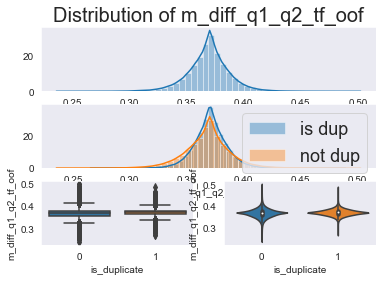

In [59]:
plot_real_feature('m_diff_q1_q2_tf_oof')

In [60]:
del(m_diff_q1_q2)

## Нормальная валидация

<img src="./../images/buben5.jpg" width="70%" />

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('./../data/tmp/11_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/11_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/11_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.4min finished
0.786160924089
{'en__l1_ratio': 0.75, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/11_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/11_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- результат: **0.33349**
- лучший результат был раньше: **0.3316**

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors, top=30))

$$\large\begin{array}{rcl}
t_0 &=& \frac{n_0}{n_0 + n_1} \Rightarrow \\
n_1 &=& \frac{n_0 t_1}{t_0}
\end{array}$$

- у трейн и тест сплита своя пропорция $t_i$

In [ ]:
class QuoraKFold():
    
    def __init__(self, n_splits=10):
        self.n_splits = n_splits
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
        
    def split(self, X, y, groups=None):
        r_split = 1 - 1.0/self.n_splits
        k = r1*d[0]/(r0*d[1])
        ix_ones = np.where(y == 1)[0]
        ix_zeros = np.where(y == 0)[0]
        for i in range(self.n_splits):
            ix_first_zeros = np.random.choice(
                ix_zeros, 
                size=int(r_split * ix_zeros.shape[0]), 
                replace=False)
            ix_first_ones = np.random.choice(
                ix_ones,
                size=int(ix_first_zeros.shape[0] * d[1]/d[0]),
                replace=False)
            
            ix_second_zeros = np.setdiff1d(ix_zeros, ix_first_zeros)
            ix_second_ones = np.random.choice(
                np.setdiff1d(ix_ones, ix_first_ones),
                size=int(ix_second_zeros.shape[0] * r1/r0),
                replace=False)
            
            ix_first = np.hstack((ix_first_zeros, ix_first_ones))
            ix_first = ix_first[np.random.choice(
                range(ix_first.shape[0]), size=ix_first.shape[0], replace=False)]
            
            ix_second = np.hstack((ix_second_zeros, ix_second_ones))
            ix_second = ix_second[np.random.choice(
                range(ix_second.shape[0]), size=ix_second.shape[0], replace=False)]
            
            yield ix_first, ix_second

In [ ]:
def log_loss_lf(y_true, y_pred):
    return log_loss(y_true, link_function(y_pred[:, 1]), eps=eps)

In [ ]:
def check_model(predictors, data=None, do_scaling=True, folder=None):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    if folder is None:
        folder = QuoraKFold(n_splits=10)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1,
        scoring=make_scorer(log_loss_lf, greater_is_better=False, needs_proba=True),
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('./../data/tmp/12_model.pkl'):
    model = check_model(predictors, folder=StratifiedKFold(n_splits=5, shuffle=True))
    print (-model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/12_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/12_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.5min finished
0.50136321542
{'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
```

In [ ]:
if not os.path.isfile('./../data/tmp/13_model.pkl'):
    model = check_model(predictors)
    print (-model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/13_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/13_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 23.4min finished
0.323176002744
{'en__l1_ratio': 1, 'en__alpha': 0.0001}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/13_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/13_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- результат: **0.33524** почти как в валидации
- лучший результат был раньше: **0.3316**
- будем надеяться что это тоже погрешность

### Факторизация вертикально сконкатенированной матрицы

<img src="./../images/mf3.png" />

In [ ]:
if not os.path.isfile('./../data/tmp/2_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.vstack((m_q1_tf, m_q2_tf))))
    with open('./../data/tmp/2_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('./../data/tmp/2_m_svd.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    with open('./../data/tmp/2_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('./../data/tmp/2_m_svd.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

In [ ]:
del(m_q1_tf, m_q2_tf)

In [62]:
m_svd_q1 = m_svd[:m_svd.shape[0]//2, :]
m_svd_q2 = m_svd[m_svd.shape[0]//2:, :]
del(m_svd)

In [ ]:
df['m_vstack_svd_q1_q2_euclidean'] = ((m_svd_q1 - m_svd_q2)**2).mean(axis=1)
plot_real_feature('m_vstack_svd_q1_q2_euclidean')

In [ ]:
num = (m_svd_q1*m_svd_q2).sum(axis=1)
den = np.sqrt((m_svd_q1**2).sum(axis=1))*np.sqrt((m_svd_q2**2).sum(axis=1))
num[np.where(den == 0)] = 0
den[np.where(den == 0)] = 1
df['m_vstack_svd_q1_q2_cosine'] = 1 - num/den
plot_real_feature('m_vstack_svd_q1_q2_cosine')

#### OOF от произведения svd вертикальной конкатенации

In [ ]:
m_svd = m_svd_q1*m_svd_q2

if not os.path.isfile('./../data/tmp/14_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/14_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/14_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 70.9min finished
-0.409563471096
{'en__l1_ratio': 1, 'en__alpha': 1e-05}
```

In [ ]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_svd)

In [ ]:
if not os.path.isfile('./../data/tmp/15_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 1, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=1.0,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/15_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/15_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print(res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_vstack_svd_mult_q1_q2_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_vstack_svd_mult_q1_q2_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_vstack_svd_mult_q1_q2_oof'] = data['y_test_pred_fixed']
del(data)
plot_real_feature('m_vstack_svd_mult_q1_q2_oof')

#### OOF от разницы svd вертикальной конкатенации

In [ ]:
m_svd = np.abs(m_svd_q1 - m_svd_q2)

if not os.path.isfile('./../data/tmp/16_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/16_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/16_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 63.4min finished
-0.439305223632
{'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
```

In [ ]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_svd, m_svd_q1, m_svd_q2)

In [ ]:
if not os.path.isfile('./../data/tmp/17_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.01,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/17_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/17_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_vstack_svd_absdiff_q1_q2_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_vstack_svd_absdiff_q1_q2_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_vstack_svd_absdiff_q1_q2_oof'] = data['y_test_pred']
del(data)
plot_real_feature('m_vstack_svd_absdiff_q1_q2_oof')

## Обрабатываем слова целиком

<img src="./../images/buben6.jpg" width="70%" />

### Лемматизированные слова

In [ ]:
nlp = spacy.load('en')
df.head()['question1'].apply(lambda s: ' '.join([c.lemma_ for c in nlp(s) if c.lemma_  != '?']))

In [ ]:
SYMBOLS = set(' '.join(string.punctuation).split(' ') + ['...', '“', '”', '\'ve'])

if not os.path.isfile('./../data/tmp/bow_lemma.pkl'):
    q1 = []

    for doc in nlp.pipe(df['question1'].values.tolist(), n_threads=16, batch_size=10000):
        q1.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])

    q2 = []

    for doc in nlp.pipe(df['question2'].values.tolist(), n_threads=16, batch_size=10000):
        q2.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])
        
    with open('./../data/tmp/bow_lemma.pkl', 'wb') as f:
        pickle.dump({
            'q1': q1,
            'q2': q2
        }, f)
else:
    with open('./../data/tmp/bow_lemma.pkl', 'rb') as f:
        tmp = pickle.load(f)
        q1 = tmp['q1']
        q2 = tmp['q2']
        del(tmp)

In [ ]:
%%time
if os.path.isfile('./../data/tmp/cv_word_lemma.pkl') and os.path.isfile('./../data/tmp/wl_freq.pkl'):
    with open('./../data/tmp/cv_word_lemma.pkl', 'rb') as f:
        cv_words = pickle.load(f)
    with open('./../data/tmp/wl_freq.pkl', 'rb') as f:
        w_freq = pickle.load(f)
else:
    cv_words = CountVectorizer(ngram_range=(1, 1), analyzer='word')
    w_freq = np.array(cv_words.fit_transform(
        [' '.join(s) for s in q1] + [' '.join(s) for s in q2]).sum(axis=0))[0, :]
    with open('./../data/tmp/cv_word_lemma.pkl', 'wb') as f:
        pickle.dump(cv_words, f)
    with open('./../data/tmp/wl_freq.pkl', 'wb') as f:
        pickle.dump(w_freq, f)

In [ ]:
if os.path.isfile('./../data/tmp/m_q1_wl.npz') and os.path.isfile('./../data/tmp/m_q2_wl.npz'):
    m_q1 = load_sparse_csr('./../data/tmp/m_q1_wl.npz')
    m_q2 = load_sparse_csr('./../data/tmp/m_q2_wl.npz')
else:
    m_q1 = cv_words.transform([' '.join(s) for s in q1])
    m_q2 = cv_words.transform([' '.join(s) for s in q2])
    save_sparse_csr('./../data/tmp/m_q1_wl.npz', m_q1)
    save_sparse_csr('./../data/tmp/m_q2_wl.npz', m_q2)

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
        np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
v_num[np.where(v_den == 0)] = 1
v_den[np.where(v_den == 0)] = 1

v_score = 1 - v_num/v_den

df['1wl_tfidf_cosine'] = v_score
plot_real_feature('1wl_tfidf_cosine')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['1wl_tfidf_l2_euclidean'] = v_score
plot_real_feature('1wl_tfidf_l2_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['1wl_tf_l2_euclidean'] = v_score
plot_real_feature('1wl_tf_l2_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

In [ ]:
if not os.path.isfile('./../data/tmp/20_model.pkl'):
    model = check_model(None, data={
        'X': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/20_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/20_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 39.9min finished
-0.365063639733
{'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/20_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/20_pred_fixed.csv', index=False)

- старый результат: **0.3316**
- внезапно новый результат: **0.30964**

In [ ]:
data={
    'X_train': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_q1_tf, m_q2_tf)

In [ ]:
if not os.path.isfile('./../data/tmp/21_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.0001,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../data/tmp/21_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('./../data/tmp/21_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]//2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]//2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_w1l_tfidf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_w1l_tfidf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_w1l_tfidf_oof'] = data['y_test_pred_fixed']
del(data)
plot_real_feature('m_w1l_tfidf_oof')

In [ ]:
predictors = df.columns[7:]
print (predictors)

In [ ]:
class QuoraKFold():
    
    def __init__(self, n_splits=10, r_split=0.7):
        self.n_splits = n_splits
        self.r_split = r_split
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
        
    def split(self, X, y, groups=None):
        if self.r_split is None:
            self.r_split = 1 - 1.0/self.n_splits
        k = r1*d[0]/(r0*d[1])
        ix_ones = np.where(y == 1)[0]
        ix_zeros = np.where(y == 0)[0]
        for i in range(self.n_splits):
            ix_first_zeros = np.random.choice(
                ix_zeros, 
                size=int(self.r_split * ix_zeros.shape[0]), 
                replace=False)
            ix_first_ones = np.random.choice(
                ix_ones,
                size=int(ix_first_zeros.shape[0] * d[1]/d[0]),
                replace=False)
            
            ix_second_zeros = np.setdiff1d(ix_zeros, ix_first_zeros)
            ix_second_ones = np.random.choice(
                np.setdiff1d(ix_ones, ix_first_ones),
                size=int(ix_second_zeros.shape[0] * r1/r0),
                replace=False)
            
            ix_first = np.hstack((ix_first_zeros, ix_first_ones))
            ix_first = ix_first[np.random.choice(
                range(ix_first.shape[0]), size=ix_first.shape[0], replace=False)]
            
            ix_second = np.hstack((ix_second_zeros, ix_second_ones))
            ix_second = ix_second[np.random.choice(
                range(ix_second.shape[0]), size=ix_second.shape[0], replace=False)]
            
            yield ix_first, ix_second


def check_model(predictors, data=None, do_scaling=True, folder=None, r_split=0.7):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    if folder is None:
        folder = QuoraKFold(n_splits=10, r_split=r_split)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1,
        scoring=make_scorer(log_loss_lf, greater_is_better=False, needs_proba=True),
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('./../data/tmp/22_model.pkl'):
    model = check_model(None, data={
        'X': df.loc[ix_train][predictors],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=True, r_split=0.7)
    print (model.best_score_)
    print (model.best_params_)
    with open('./../data/tmp/22_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('./../data/tmp/22_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 23.9min finished
-0.307676722634
{'en__l1_ratio': 1, 'en__alpha': 0.0001}
```

In [ ]:
display(
    eli5.sklearn.explain_linear_classifier_weights(
        model.best_estimator_.steps[1][1],
        feature_names=predictors.tolist(),
        top=len(predictors)))

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test, predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('./../data/tmp/22_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/22_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- внезапно хуже: **0.32406**
- если не делать коррекцию среднего: **0.40287**

In [ ]:
del(m_q1, m_q2)

# Черная магия

<img src="./../images/buben7.jpg" width="70%" />

In [ ]:
predictors = df.columns[7:]
print (predictors)

In [ ]:
xgb_models = []
if not os.path.isfile('./../data/tmp/25_pred_fixed.csv'):
    def log_loss_lf_xgb(y_pred, y_true):
        return 'llf', log_loss(y_true.get_label(), link_function(y_pred), eps=eps)

    xgb_params = {
        'max_depth': 9, 
        'learning_rate': 0.1,
        'n_estimators': 2500, 
        'objective': 'binary:logistic',
        'nthread': 16, 
        'gamma': 0, 
        'subsample': 0.75, 
        'colsample_bytree': 0.75, 
        'colsample_bylevel': 1,
        'reg_alpha': 0, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1
    }

    y_test = []
    folder = QuoraKFold(n_splits=10, r_split=0.7)
    splits = folder.split(np.zeros(ix_train.shape[0]), df.loc[ix_train, 'is_duplicate'])
    for ix_first, ix_second in tqdm_notebook(splits, total=10):

        model = xgb.XGBClassifier(silent=True).set_params(**xgb_params)
        model = model.fit(df.loc[ix_first, predictors], df.loc[ix_first, 'is_duplicate'], 
                          eval_set=[(df.loc[ix_second, predictors], df.loc[ix_second, 'is_duplicate'])], 
                          eval_metric=log_loss_lf_xgb,
                          early_stopping_rounds=100, 
                          verbose=False)
        y_test.append(model.predict_proba(df.loc[ix_test, predictors])[:, 1])
        xgb_models.append(model)

    y_test_pred = np.array(y_test).T.mean(axis=1)
    y_test_pred_fixed = link_function(y_test_pred)
    
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('./../data/tmp/25_pred_fixed.csv', index=False)

In [ ]:
if not os.path.isfile('./../data/tmp/bm1.pkl'):
    with open('./../data/tmp/bm1.pkl', 'wb') as f:
        pickle.dump(xgb_models, f)
else:
    with open('./../data/tmp/bm1.pkl', 'rb') as f:
        xgb_models = pickle.load(f)

In [ ]:
model = xgb_models[0]

In [ ]:
xgb.plot_importance(model)
plt.show()

- немного черной магии дает: **0.29936**
- на момент сабмита это **244/1880**

## [Yuriy Guts] Save derived features

In [67]:
from pygoose import *

In [68]:
project = kg.Project.discover()

In [69]:
feature_list_id = '3rdparty_mephistopheies'

In [71]:
feature_names = df.columns[9:]
feature_names

Index(['abs_diff_len1_len2', 'log_abs_diff_len1_len2', 'ratio_len1_len2',
       'log_ratio_len1_len2', 'unigram_jaccard', 'unigram_all_jaccard',
       'unigram_all_jaccard_max', 'bigram_jaccard', 'bigram_all_jaccard',
       'bigram_all_jaccard_max', 'trigram_jaccard', 'trigram_all_jaccard',
       'trigram_all_jaccard_max', 'trigram_tfidf_cosine',
       'trigram_tfidf_l2_euclidean', 'trigram_tfidf_l1_euclidean',
       'trigram_tf_l2_euclidean', 'm_q1_q2_tf_oof', 'm_q1_q2_tf_svd0',
       'm_q1_q2_tf_svd1', 'm_q1_q2_tf_svd100_oof', 'm_diff_q1_q2_tf_oof'],
      dtype='object')

In [72]:
X_train = df.loc[ix_train][feature_names].values
X_test = df.loc[ix_test][feature_names].values

In [73]:
X_train.shape, X_test.shape

((404290, 22), (2345796, 22))

In [75]:
feature_names = [
    'meph_' + feature_name
    #for feature_name in predictors.tolist()
    for feature_name in feature_names
]

In [77]:
project.save_features(X_train, X_test, feature_names, feature_list_id)